<a href="https://colab.research.google.com/github/smreynolds92/Great-Learning/blob/main/milestone_2_solution_notebook_model_monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone 2: Model Monitoring

**Business Context: **

Fashion Haven has successfully implemented a predictive model for sales revenue estimation based on their advertising campaigns across different media sources (TV, Newspaper, Radio). The model has been deployed in production, and it plays a crucial role in guiding the company's advertising budget allocation and overall marketing strategy. However, after the initial deployment, the company faces the challenge of monitoring the model's performance and ensuring its ongoing reliability and accuracy. Over time, the business environment may change, advertising trends could evolve, or external factors may impact customer behavior, all of which can influence the model's predictive capabilities. Fashion Haven needs to develop a robust model monitoring system to identify and address potential issues with the deployed sales revenue prediction model.
The goal of this model monitoring assignment is to implement a proactive approach to ensure the model's continued effectiveness and identify any degradation in its performance. By regularly monitoring the model, Fashion Haven can maintain the quality of predictions, make timely updates, and take corrective actions as needed.


The model monitoring system should provide the following key functionalities:

1. Data Drift Detection: The business environment is dynamic, and changes in customer behavior, market trends, or competitor strategies may cause data distribution to drift over time. The monitoring system should identify and measure data drift in the input features used by the model, helping the team understand how well the model adapts to new data.

2. Model Drift Checks: Regular calibration checks will ensure that the model's predicted probabilities align with the observed outcomes. If the model becomes miscalibrated, corrective actions should be taken to recalibrate it for accurate probability estimates.

**Data Description:**

The data contains the different attributes of the advertising business. The detailed data dictionary is given below.

1. TV: Expenditure on media resource- TV

2. Radio: Expenditure on media resource- Radio

3. NewsPaper: Expenditure on media resource- Newspaper

4. Sales: Target Column - Amount of Sales


*** I have used the class workbooks, my previous projects, and internet searches as an example for much of my coding in this project.

## Connect to the workspace

In [ ]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    CodeConfiguration
)

from azure.storage.blob import BlobServiceClient

In [ ]:
# Get a handle to the workspace by providing the workspace subscription_id, resource_group_name, and workspace_name
ml_client = MLClient(
    credential=credential,
    subscription_id="a957f7f0-2b65-4c7d-9622-3fe86a8388b8",
    resource_group_name="test-resourceSR",
    workspace_name="demo-azuremlSR",
)

**Observation:**
- Using the subscription_id, resource_group_name, and workspace_name from this Azure session/setup.

## Create a compute resource to run the jobs



In [ ]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster-sr"

try:
    # Checking to see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_D2_V3",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=1,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=300,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Passing the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster).result()

print(
    f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}"
)

Creating a new cpu compute target...
AMLCompute with name cpu-cluster-sr is created, the compute size is STANDARD_D2_V3


**Observation:**
- The compute cluster is created and has a STANDARD_D2_V3 size.

## Configure and submit your training job

#### Prepare the training script:

In [ ]:
# Creating a directory to store the training script file.
import os

src_dir = "./src"
os.makedirs(src_dir, exist_ok=True)

**Observation:**
- Creating a folder for the .py files in this notebook.

In [ ]:
%%writefile {src_dir}/main.py

import os
import mlflow
import argparse

import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor

def main():

    mlflow.start_run() # Start an MLflow run

    parser = argparse.ArgumentParser() # Create an argument parser
    parser.add_argument("--data", type=str)  # Add an argument for the data file path
    parser.add_argument("--learning-rate", required=False, default=0.1, type=float)
    parser.add_argument("--max-depth", required=False, default=4, type=float)
    parser.add_argument("--n-estimators", required=False, default=100, type=int)
    args = parser.parse_args()

    advertise = pd.read_csv(args.data)

    from sklearn.model_selection import train_test_split
    X = advertise.drop(columns=["Sales"])
    X = pd.get_dummies(X,drop_first=True)

    y = advertise["Sales"]

    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
    )
    # Create a Gradient Boosting Regressor model with the specified hyperparameters
    model_gbr = GradientBoostingRegressor(
        n_estimators=args.n_estimators,
        learning_rate=args.learning_rate,
        max_depth=args.max_depth
    )


    model_gbr.fit(X_train, y_train)

    rmse = model_gbr.score(X_test, y_test)

    mlflow.log_metric("RMSE", float(rmse))

    print("Registering model pipeline")
     # Log the trained model to MLflow
    mlflow.sklearn.log_model(
        sk_model=model_gbr,
        registered_model_name="gbr_advertise_predictor",
        artifact_path="gbr_advertise_predictor"
    )
    # End the MLflow run

    mlflow.end_run()


if __name__ == '__main__':
    main()

Overwriting ./src/main.py


**Observation:**
- The main.py file is created and stored in the ./src folder.  The model that is chosen is the GradientBoostingRegressor which is good for predictive problems.  The primary metric chosen is RMSE, which will measures how well a statistical model predicts an target value/accuracy.

#### Define training job:



In [ ]:
# Import the necessary modules
from azure.ai.ml import command
from azure.ai.ml import Input

# Define a new AML job using the `command` function
job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="./data/advertising_raw.csv" # The path to the input data file
                )),
    # Specify the directory containing the code to be run in the job
    code="./src/",
    # Specify the command to be run in the job, including the input data and parameters as command line arguments
    command="python main.py --data ${{inputs.data}}",
    # Specify the environment to be used for the job
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    # Specify the compute target to be used for the job
    compute="cpu-cluster-sr",
    # Specify the name of the experiment for the job
    experiment_name="advertise_exper_test",
     # Specify the display name for the job
    display_name="advertise_display_name",
)

**Observation:**
- The processing job is configured with parameters for this workbook/milestone.

#### Submit the job:

In [ ]:
# ml_client.create_or_update will create a new job if it does not exist or update the existing job if it does
ml_client.create_or_update(job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Experiment,Name,Type,Status,Details Page
advertise_exper_test,goofy_music_dcb6rtf5x2,command,Starting,Link to Azure Machine Learning studio


**Observation:**
- The processing job is run and a link to the jobs is also created.  The job did complete, but there are some notes for your information/warnings.

## Find and register the model

In [ ]:
registered_model = ml_client.models.get(
    name="gbr_advertise_predictor",
    version=3
)

**Observation:**
- Collecting the registered_model information.

## Create Online Endpoint


#### Configure the endpoint:

In [ ]:
# Import required libraries, although some have been called earlier
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
from azure.ai.ml.constants import AssetTypes

In [ ]:
# Importing the required modules
import random
import string

# Creating a unique endpoint name by including a random suffix

# Defining a list of allowed characters for the endpoint suffix
allowed_chars = string.ascii_lowercase + string.digits

# Generating a random 5-character suffix for the endpoint name by choosing
# characters randomly from the list of allowed characters
endpoint_suffix = "".join(random.choice(allowed_chars) for x in range(5))

# Creating the final endpoint name by concatenating a prefix string
# with the generated suffix string
endpoint_name = "advertise-endpoint-" + endpoint_suffix

**Observation:**
- Creating an endpoint name that is unique and appends a randomly chosen 5 characters at the end of the name.

In [ ]:
print(f"Endpoint name: {endpoint_name}")

Endpoint name: advertise-endpoint-neta6


**Observation:**
- Printing the name of the endpoint to show the unique name with the randomly chosen extra 5 characters.

In [ ]:
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,
    # Name of the endpoint, should be unique within your deployment
    description="An online endpoint serving an MLflow model for the pima classification task",
    # A string describing the purpose of the endpoint
    auth_mode="key",
    # Authentication mode to use for the endpoint (in this case, using an API key)
    tags={"foo": "bar"},
    # A dictionary of key-value pairs that can be used to tag the endpoint
)

**Observation:**
- Configuring the endpoint with a description, auth_mode, and tags.

#### Create the endpoint:


In [ ]:
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://advertise-endpoint-neta6.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://advertise-endpoint-neta6.eastus.inference.ml.azure.com/swagger.json', 'name': 'advertise-endpoint-neta6', 'description': 'An online endpoint serving an MLflow model for the pima classification task', 'tags': {'foo': 'bar'}, 'properties': {'createdBy': 'Scharon Reynolds', 'createdAt': '2024-12-15T18:41:02.174997+0000', 'lastModifiedAt': '2024-12-15T18:41:02.174997+0000', 'azureml.onlineendpointid': '/subscriptions/a957f7f0-2b65-4c7d-9622-3fe86a8388b8/resourcegroups/test-resourcesr/providers/microsoft.machinelearningservices/workspaces/demo-azuremlsr/onlineendpoints/advertise-endpoint-neta6', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/a957f7f0-2b65-4c7d-9622-3fe86a8388b8/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oeidp:90a

**Observation:**
- Creating the endpoint.  Information about the endpoint creation is shown above for further details.

## Create a blue deployment

#### Curating the deployment script:

In [ ]:
%%writefile {src_dir}/score.py

# Import necessary libraries and modules
import logging
import os
import json
import mlflow
from io import StringIO
from mlflow.pyfunc.scoring_server import infer_and_parse_json_input, predictions_to_json

######################LOGGER#####################
# Set up Azure logging
import logging
from logging import Logger
from opencensus.ext.azure.log_exporter import AzureLogHandler

# Connect to Application Insights and set logging level to INFO
application_insights_connection_string= 'InstrumentationKey=755d8ba3-0edc-46bf-b3c5-0a64be0da82b;IngestionEndpoint=https://eastus-8.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus.livediagnostics.monitor.azure.com/;ApplicationId=d4ca8d1c-0d84-40c0-aa3d-ae0d561e8e70'
handler = AzureLogHandler(
connection_string=application_insights_connection_string)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

####################################################

# Define the init() function to load the MLflow model
def init():
    global model
    global input_schema
    # "model" is the path of the mlflow artifacts when the model was registered. For automl
    # models, this is generally "mlflow-model".
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "gbr_advertise_predictor")
    model = mlflow.pyfunc.load_model(model_path)
    input_schema = model.metadata.get_input_schema()

# Define the run() function to make predictions using the loaded model
def run(raw_data):
    # Parse input data
    json_data = json.loads(raw_data)
    if "input_data" not in json_data.keys():
        raise Exception("Request must contain a top level key named 'input_data'")
    serving_input = json.dumps(json_data["input_data"])
    data = infer_and_parse_json_input(serving_input, input_schema)

    # Make predictions
    predictions = model.predict(data)

    # Log the input data and predictions to Azure
    logger.info("Data:{0},Predictions:{1}".format(str(data),str(predictions)))

    # Convert predictions to JSON format and return
    result = StringIO()
    predictions_to_json(predictions, result)
    return result.getvalue()


Overwriting ./src/score.py


**Observation:**
- The score.py file is created and stored in the ./src folder.

#### Configure the deployment:

In [ ]:
# Create a new deployment with name "blue"
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    # Use the previously generated endpoint name
    endpoint_name=endpoint_name,
    # Use the registered model
    model=registered_model,
    # Use the latest environment
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",
    # Use the code in the "./src" directory and the "score.py" script
    code_configuration=CodeConfiguration(
        code="./src", scoring_script="score.py"
    ),
    # Use a single instance of type "Standard_E2s_v3"
    instance_type="Standard_E2s_v3",
    instance_count=1,
    # Enable Application Insights for the deployment
    app_insights_enabled=True,
)

**Observation:**
- Creating a new deployment named blue with parameters.

#### Create the deployment:

In [ ]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Check: endpoint advertise-endpoint-neta6 exists


................................................................................

ManagedOnlineDeployment({'private_network_connection': None, 'package_model': False, 'provisioning_state': 'Succeeded', 'endpoint_name': 'advertise-endpoint-neta6', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/a957f7f0-2b65-4c7d-9622-3fe86a8388b8/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/odidp:90a3ab6c-6834-47bd-9549-333482230f0e:78119f0f-0388-4031-89a8-fe978e2176cc?api-version=2023-04-01-preview'}, 'print_as_yaml': False, 'id': '/subscriptions/a957f7f0-2b65-4c7d-9622-3fe86a8388b8/resourceGroups/test-resourceSR/providers/Microsoft.MachineLearningServices/workspaces/demo-azuremlSR/onlineEndpoints/advertise-endpoint-neta6/deployments/blue', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/smreynolds20221sr/code/Users/smreynolds2022/wk9_test', 'creation_context': <azure.ai.ml._restclient.v2023_04_01_pre

**Observation:**
- Creating or updating the blue deployment.  Information about this deployment are shown above for further details.

## Test the deployment (using a "sample_data.json"file)

In [ ]:
model_predictions_azure = ml_client.online_endpoints.invoke(
        endpoint_name=endpoint_name,# Specify the name of the endpoint to invoke
        deployment_name="blue",
        request_file="data/sample-request-sklearn.json"   # Provide the file containing the sample data for making predictions
)

**Observation:**
- Configuring the blue deployment with a sample json.

In [ ]:
# Data is "stored" as a string
model_predictions_azure

'"{\\"predictions\\": [22.24728641988061, 26.96807766202868, 22.24728641988061, 15.631204537022658, 16.734740146543242, 21.789873803766852, 26.919070242630816, 21.789873803766852, 15.712775332194084, 16.662602784854865, 22.19522109785836, 27.0039742577298, 22.34710987631212, 15.624083644347497, 16.676526333645267, 23.70787087923063, 27.0039742577298, 24.67582813377342, 15.712775332194084]}"'

In [ ]:
# Data is coverted to a literal
import ast
ast.literal_eval(model_predictions_azure)

'{"predictions": [22.24728641988061, 26.96807766202868, 22.24728641988061, 15.631204537022658, 16.734740146543242, 21.789873803766852, 26.919070242630816, 21.789873803766852, 15.712775332194084, 16.662602784854865, 22.19522109785836, 27.0039742577298, 22.34710987631212, 15.624083644347497, 16.676526333645267, 23.70787087923063, 27.0039742577298, 24.67582813377342, 15.712775332194084]}'

In [ ]:
# Access the converted Python data structure
import ast
model_predictions_azure_list_2 = ast.literal_eval(ast.literal_eval(model_predictions_azure))
model_predictions_azure_list_2

{'predictions': [22.24728641988061,
  26.96807766202868,
  22.24728641988061,
  15.631204537022658,
  16.734740146543242,
  21.789873803766852,
  26.919070242630816,
  21.789873803766852,
  15.712775332194084,
  16.662602784854865,
  22.19522109785836,
  27.0039742577298,
  22.34710987631212,
  15.624083644347497,
  16.676526333645267,
  23.70787087923063,
  27.0039742577298,
  24.67582813377342,
  15.712775332194084]}

In [ ]:
# Extract the predicted values from the dictionary and convert them to a list or array-like object
predicted_values = model_predictions_azure_list_2['predictions']

**Observation:**
- The predicted_values will be used for the test listed below in this workbook.

## Target Check

This is a very critical check especially when the ground truth is delayed. By comparing the distribution of the predictions with the target present in the training data, we can flag deviations beyond expected amount of variation.

#### Compare the distribution of predictions from the endpoint with the distribution of the target in the training data (advertising_raw.csv)

In [ ]:
# Access the training data
import pandas as pd
training_data = pd.read_csv("data/advertising_raw.csv")

In [ ]:
# The data has 200 rows and 4 columns of data
training_data.shape

(200, 4)

In [ ]:
pip install seaborn==0.12.2

Note: you may need to restart the kernel to use updated packages.


**Observation:**
- Installing the seaborn 0.12.2 version

In [ ]:
# General imports required for testing
import json
import ast
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chi2_contingency, ttest_rel

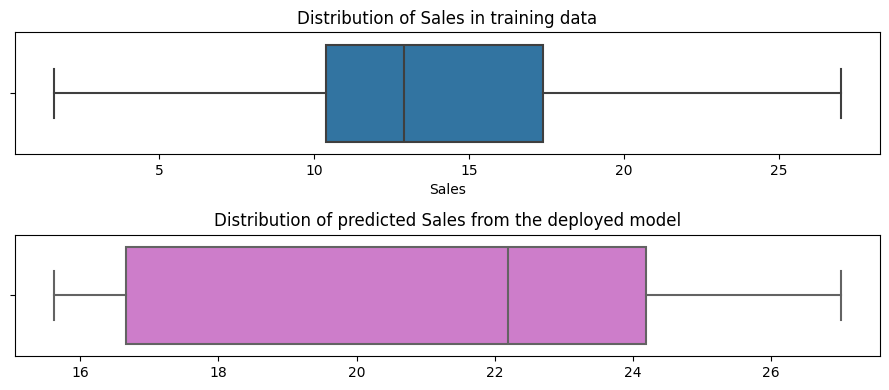

In [ ]:
# Boxplots of the Distribution of Sales of Training Data, and the Distribution of predicted Sales from the Deployed Model
plt.figure(figsize=(9, 4))
plt.subplot(211)
sns.boxplot(x='Sales', data=training_data)
plt.title("Distribution of Sales in training data")
plt.subplot(212)
sns.boxplot(x=predicted_values, color='#DA70D6')
plt.title("Distribution of predicted Sales from the deployed model")
plt.tight_layout()

**Observation:**
- Since the box-plots of the training data and predicted sales do not overlap well, this could be a warning sign that the target distribution in production has drifted away from what the model was trained on, which could lead to poor predictions.

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


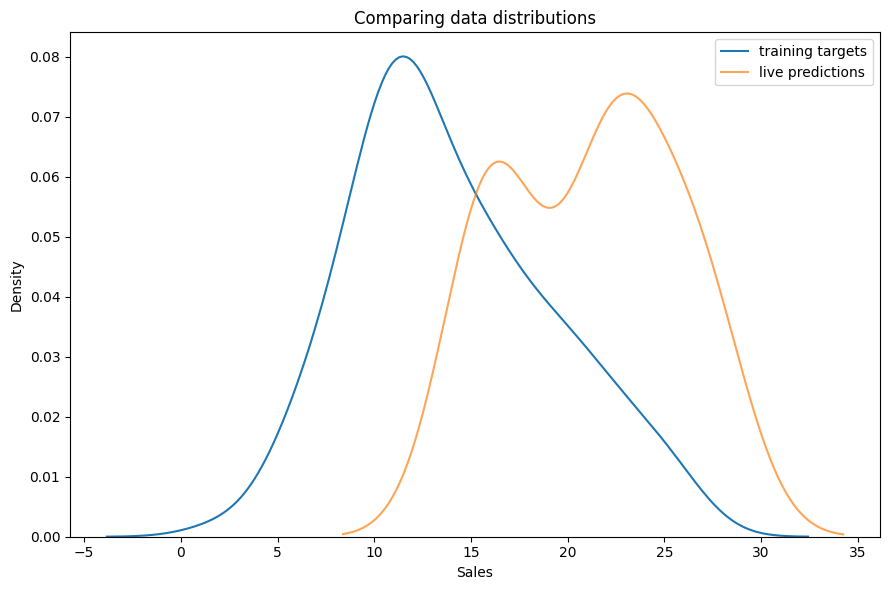

In [ ]:
# Plot comparing the Data Distribution between the Training targets and the Live predictions
plt.figure(figsize=(9, 6))
sns.kdeplot(x='Sales', data=training_data, label='training targets')
sns.kdeplot(x=predicted_values, label='live predictions', alpha=.7)
plt.legend()
plt.title('Comparing data distributions')
plt.tight_layout()

Note: Using plots state difference between the predictions coming from the endpoint and the distribution of targets in the training data. (Conclusion)

**Observation:**
- The shift to the right of the live data could suggest that the live data is moving towards higher values of the target variable compared to the training data.
-  The double peak of the live data could suggest that the distribution of the target variable in the live data is fundamentally different from the training data.

#### Kolmogorov-Smirnov test:

To confirm the absence of target drift, we use the Kolmogorov-Smirnov (K-S) test. K-S test is a statistical method used to compare two probability distributions and determine if they significantly differ from each other. In the context of testing the difference between the distributions of model predictions and the distribution of targets in training data, the K-S test can help assess if there is any deviation or drift.

Plot:

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


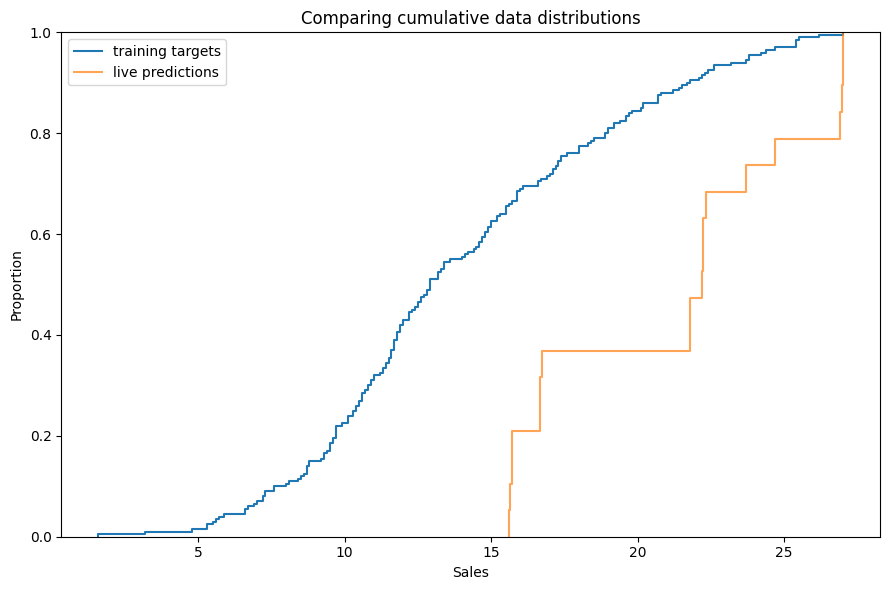

In [ ]:
# Comparing the cumulative data distributions of the training targets and the live predictions
plt.figure(figsize=(9, 6))
sns.ecdfplot(x='Sales', data=training_data, label='training targets')
sns.ecdfplot(x=predicted_values, label='live predictions', alpha=.7)
plt.legend()
plt.title('Comparing cumulative data distributions')
plt.tight_layout()

**Observation:**
- With the live predictions shifted to the right and stair-stepping while the training target is more of a curve could indicate live data drift or feature drift.

K-S Test:

In [ ]:
# Collecting the p_value for the K-S Test
statistic, p_value = ks_2samp(
            training_data["Sales"].values,
            predicted_values
)

In [ ]:
# Showing the p_value
p_value

6.953449435462539e-08

Note: Using p-value outcome, state difference between the model predictions and the target distribution in the training data

**Observation:**
- Since the p_value is < 0.05, we can say that the there is a difference between the live predictions and the training targets.  The training targets need to be reviewed especially for outliers and re-evaluated.

## Data Drift

We define data drift as the phenomenon of deviation or changes occurring between the distribution or characteristics of the training features and the corresponding live features used for real-time predictions or analysis. It indicates a shift in the underlying data generating process and can have significant implications for the performance and reliability of machine learning models or data-driven systems.

Note: Use "advertising_synthetic.csv" to check for data drift

In [ ]:
# Collecting the data from the synthetic file
sample = pd.read_csv("data/advertising_synthetic.csv")

In [ ]:
# Showing the information about the data in the synthetic file
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         49 non-null     float64
 1   Radio      49 non-null     float64
 2   Newspaper  49 non-null     float64
 3   Sales      49 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


In [ ]:
# Showing the function of the crosstab feature, but this is usually used between categorial features
# and there are no categorical features in this dataset
pd.crosstab(training_data['Newspaper'], sample['Newspaper'])

Newspaper,0.3,1.0,1.8,4.0,5.0,7.2,7.4,8.5,11.6,12.6,...,52.9,53.4,55.8,58.4,58.5,65.9,69.2,69.3,75.0,114.0
Newspaper,,,,,,,,,,,,,,,,,,,,,
0.3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7.2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7.4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8.5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11.6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


**Observation:**
- Just showing crosstab function as an example - this is usually used for categorical features.

In [ ]:
# Creating the feature to collect drift variables and setting the threshold to 0.05
threshold = 0.05
features_with_data_drift = []

In [ ]:
# Setting the Sales column as the target and the other feature columns as numeric_features
# and there are no categorical_features in this dataset
target = "Sales"
numeric_features = ['TV', 'Radio', 'Newspaper']
categorical_features = []

In [ ]:
for k, feature in enumerate(sample.columns):
    # Check if the feature is numeric
    # Perform the Kolmogorov-Smirnov test between the corresponding feature in the training and sample data
    if feature in numeric_features:
        statistic, p_value = ks_2samp(
            training_data[feature].values,
            sample[feature].values
        )

        print (feature)
        print (p_value)

        if p_value < threshold:
            features_with_data_drift.append(feature)
    # Check if the feature is categorical
    # Perform the chi-squared test between the corresponding feature in the training and sample data
    elif feature in categorical_features:
        statistic, p_value, dof, expected = chi2_contingency(
            pd.crosstab(
                training_data[feature],
                sample[feature]
            ).values
        )

        print (feature)
        print (p_value)

        # Add the feature to the list of features with data drift
        if p_value < threshold:
            features_with_data_drift.append(feature)

TV
0.8637238387761248
Radio
0.7847301575620733
Newspaper
0.513432781899389


**Observation:**
- The p_value for all 3 columns is > 0.05

In [ ]:
# Showing the features with data drift
features_with_data_drift

[]

Note: Sate if data drift has been observed in an feature or not

**Observation:**
- There is no data drift when the training data is tested against the synthetic data.

## Model Drift

To confirm model drift, we compare the ground truth of live data with the predictions from the deployed model. This involves extracting samples where the predictions and ground truth are compared, followed by conducting a statistical test to determine if there is a significant difference between the model predictions and the ground truth.

For regression problems where the ground truth is readily available, we can compare the model's performance on a random sample with the ground truth observed in that sample. This comparison utilizes a paired two-sample t-test since the exact same sample is presented to both the deployed model and the ground truth. If the ground truth is not immediately available, we can estimate it manually and then compare the model's performance on the random sample with the manually estimated ground truth, again employing a paired two-sample t-test. In cases where manual estimation is not possible, we combine the ground truth (when available) with the predictions on the sample and perform a paired two-sample t-test for comparison.


Note: Use "advertising_ground_truth.csv" to check for Model drift

In [ ]:
# Reading the file to check Model Drift which has the target value to check against the predicted values
ground_truth_sales = pd.read_csv('data/advertising_ground_truth.csv')

In [ ]:
# Showing the number of rows in the dataset
len(ground_truth_sales)

19

In [ ]:
# Showing the last five rows in the dataset
ground_truth_sales.tail()

,Sales
14,19.0
15,22.4
16,12.5
17,24.4
18,11.3


In [ ]:
# Perform a paired two-sample t-test
two_sample_ttest = ttest_rel(predicted_values, ground_truth_sales['Sales'])

In [ ]:
# Showing the p_value for the Model Drift
two_sample_ttest.pvalue

5.207343777936449e-05

Note: on the basis of p-value outcome state if there is significance difference between the model predictions and ground truth.

**Observation:**
- Since the p_value is < 0.05, we can say that there is a significant difference between the model predictions and the ground truth.

----------------------------------------------------------------------------------------

# Note: Refer to MLS and LVS to perform this section of the project

### **Conclusions**

- The Target Check showed the p_value is < 0.05, we can say that the there is a difference between the live predictions and the training targets.  The training targets need to be reviewed especially for outliers and re-evaluated.
- The Data Drift section did not show drift for any variables.  These were the p_values for the 3 columns: TV 0.8637238387761248, Radio 0.7847301575620733, Newspaper 0.513432781899389.
- The Model Drift showed the p_value is < 0.05, we can say that there is a significant difference between the model predictions and the ground truth.
These are some items that should be looked at for the Model Drift:

1. - Retrain the model with recent data.
3. - Check for concept drift - is there data that needs to be included/excluded.
5. - Continue to monitor model performance.       
7. - Check to see if there are other factors that could be affecting the data - market, seasonality, etc..